In [1]:
gpu_info = !nvidia-smi -i 0
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

from datetime import datetime
from functools import partial
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.models import resnet
from tqdm import tqdm
import argparse
import json
import math
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import sklearn.manifold

Fri Mar 31 00:21:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
train_transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(), 
    # transforms.RandomResizedCrop(size=28, scale=(0.2, 1.)),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, ), (0.5))])


test_transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(), 
    # transforms.RandomResizedCrop(size=28, scale=(0.2, 1.)),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, ), (0.5))])


In [3]:
# data prepare
dataset = MNIST(root='./DATA', train=True, transform=train_transform, download=True)
train_data = torch.utils.data.Subset(dataset, range(100))
train_loader = DataLoader(train_data, batch_size=50, shuffle=True, num_workers=1, pin_memory=True, drop_last=True)

# memory_data = MNIST(root='./DATA', train=True, transform=test_transform, download=True)
# memory_loader = DataLoader(memory_data, batch_size=args.batch_size, shuffle=False, num_workers=10, pin_memory=True)

test_data = MNIST(root='./DATA', train=False, transform=test_transform, download=True)
test_loader = DataLoader(test_data, batch_size=50, shuffle=False, num_workers=10, pin_memory=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./DATA/MNIST/raw/train-images-idx3-ubyte.gz to ./DATA/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./DATA/MNIST/raw/train-labels-idx1-ubyte.gz to ./DATA/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./DATA/MNIST/raw/t10k-images-idx3-ubyte.gz to ./DATA/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./DATA/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./DATA/MNIST/raw



/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [4]:
class Encoder(torch.nn.Module):
    "Encoder network"
    def __init__(self):
        super(Encoder, self).__init__()
        # L1 (?, 28, 28, 1) -> (?, 28, 28, 32) -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=0.2)
            )
        # L2 (?, 14, 14, 32) -> (?, 14, 14, 64) -> (?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=0.2)
            )
        # L3 (?, 7, 7, 64) -> (?, 7, 7, 128) -> (?, 4, 4, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            torch.nn.Dropout(p=0.2)
            )
        self._to_linear = 4 * 4 * 128
        self.fc = torch.nn.Linear(in_features=4 * 4 * 128, out_features=128)
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1) # Flatten them for FC
        x = self.fc(x)
        return x

In [5]:
mod = Encoder()

In [6]:
for name, param in mod.named_parameters():
  if name not in ["fc.weight", "fc.bias"]:
    param.requires_grad = False

In [7]:
for name, param in mod.named_parameters():
  if param.requires_grad:
    print(name)

fc.weight
fc.bias


In [8]:
class Classifier(torch.nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.encoder_q = Encoder()
        self.fl = torch.nn.Linear(in_features=128, out_features=10)
    def forward(self, x):
      x = self.encoder_q(x)
      x = self.fl(x)

      return x

In [9]:
down_stream = Classifier()

In [10]:
for name, param in down_stream.encoder_q.named_parameters():
  if name not in ["fc.weight", "fc.bias"]:
    param.requires_grad = False

In [11]:
for name, param in down_stream.named_parameters():
  if param.requires_grad:
    print(name)

encoder_q.fc.weight
encoder_q.fc.bias
fl.weight
fl.bias


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
down_stream.encoder_q.load_state_dict(torch.load("./drive/MyDrive/Colab Notebooks/Projet Deep learning/moco_final_q.pt"))
down_stream.encoder_q.eval()

Encoder(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
 

In [14]:
device = "cuda:0" if torch.cuda.is_available() else "cpu" #0 indicates the GPU you gonna use 
print(f"Using {device} device")

Using cuda:0 device


In [15]:
criterion =  nn.CrossEntropyLoss().cuda()
# Optimizing method
optimizer = torch.optim.Adam(down_stream.parameters(), lr=0.001)
down_stream.to(device)

Classifier(
  (encoder_q): Encoder(
    (layer1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.2, inplace=False)
    )
    (layer2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.2, inplace=False)
    )
    (layer3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=1, dila

In [16]:
def get_accuracy(y_true, y_pred):
    return int(np.sum(np.equal(y_true, y_pred))) / y_true.shape[0]

tensor(6)

In [17]:
from tqdm import tqdm # you can use the tqdm function in a loop to display the evolution of the computations

# Set number of epochs
epochs = 25
# Initialize train and validation loss to store them during training
loss_valid = []
loss_train = []
# Initialize train and validation accuracy to store them during training
acc_valid = []
acc_train = []

# Start looping over epochs
for epoch in tqdm(range(epochs)) :
  # Training
  down_stream.train()
  running_loss = 0.0

  for idx, batch in enumerate(train_loader):
    inputs, labels = batch
    inputs = inputs.cuda()
    labels = labels.cuda()

    #zero the parameter gradients
    optimizer.zero_grad()

    #forward + backward + optimize

    out = down_stream(x = inputs)
    loss = criterion(out, labels)
    loss.backward()
    optimizer.step()

    #print statistics
    running_loss += loss.item()
    if idx % 10 == 0:
      print(f'epoch{epoch+1}, loss:{loss.item()}')
 

  # Compute loss and accuracy after an epoch on the train and valid set
  # net.eval()
  # with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs

  4%|▍         | 1/25 [00:06<02:25,  6.05s/it]

epoch1, loss:2.326517105102539


  8%|▊         | 2/25 [00:06<00:58,  2.56s/it]

epoch2, loss:2.2263343334198


 12%|█▏        | 3/25 [00:06<00:31,  1.44s/it]

epoch3, loss:2.113813877105713


 16%|█▌        | 4/25 [00:06<00:19,  1.09it/s]

epoch4, loss:2.0077359676361084


 20%|██        | 5/25 [00:06<00:12,  1.60it/s]

epoch5, loss:1.925462245941162


 24%|██▍       | 6/25 [00:06<00:08,  2.20it/s]

epoch6, loss:1.7961337566375732


 28%|██▊       | 7/25 [00:06<00:06,  2.92it/s]

epoch7, loss:1.705104947090149


 32%|███▏      | 8/25 [00:06<00:04,  3.72it/s]

epoch8, loss:1.7694915533065796


 36%|███▌      | 9/25 [00:06<00:03,  4.57it/s]

epoch9, loss:1.55448317527771


 40%|████      | 10/25 [00:07<00:02,  5.37it/s]

epoch10, loss:1.542381763458252


 44%|████▍     | 11/25 [00:07<00:02,  6.11it/s]

epoch11, loss:1.347780704498291


 48%|████▊     | 12/25 [00:07<00:01,  6.69it/s]

epoch12, loss:1.4467109441757202


 52%|█████▏    | 13/25 [00:07<00:01,  7.25it/s]

epoch13, loss:1.2112797498703003


 56%|█████▌    | 14/25 [00:07<00:01,  7.62it/s]

epoch14, loss:1.1258729696273804


 60%|██████    | 15/25 [00:07<00:01,  7.85it/s]

epoch15, loss:1.1796096563339233


 64%|██████▍   | 16/25 [00:07<00:01,  7.89it/s]

epoch16, loss:1.1836974620819092


 68%|██████▊   | 17/25 [00:07<00:00,  8.04it/s]

epoch17, loss:1.0167949199676514


 72%|███████▏  | 18/25 [00:08<00:00,  8.33it/s]

epoch18, loss:0.9563781023025513


 76%|███████▌  | 19/25 [00:08<00:00,  8.45it/s]

epoch19, loss:0.8780006170272827


 80%|████████  | 20/25 [00:08<00:00,  8.65it/s]

epoch20, loss:0.9836763739585876


 84%|████████▍ | 21/25 [00:08<00:00,  8.72it/s]

epoch21, loss:0.7409842610359192


 88%|████████▊ | 22/25 [00:08<00:00,  8.66it/s]

epoch22, loss:0.6289089322090149


 92%|█████████▏| 23/25 [00:08<00:00,  8.69it/s]

epoch23, loss:0.742475152015686


 96%|█████████▌| 24/25 [00:08<00:00,  8.64it/s]

epoch24, loss:0.5766220092773438


100%|██████████| 25/25 [00:08<00:00,  2.84it/s]

epoch25, loss:0.5106623768806458


In [18]:
output_fn = nn.Softmax(dim=1)


def train_func(train_loader, val_loader, model=None, epochs:int=None, optimizer=None, criterion=None):

  loss_valid,acc_valid =[],[]
  loss_train,acc_train =[],[]

  for epoch in tqdm(range(epochs)):

    # Training
    model.train()
    running_loss = 0.0
    for idx,batch in enumerate(train_loader):

      # get the inputs; batch is a list of [inputs, labels]
      inputs,labels=batch
      inputs=inputs.to(device) #train on GPU
      labels=labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      out = model(x=inputs)
      loss = criterion(out, labels)
      loss.backward()
      optimizer.step()

    # compute loss and accuracy after an epoch on the train and valid set
    model.eval()
    with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
      idx = 0
      for batch in val_loader:
        inputs,labels=batch
        inputs=inputs.to(device)
        labels=labels.to(device)
        if idx==0:
          t_out = model(x=inputs)
          t_loss = criterion(t_out, labels).view(1).item()
          t_out = output_fn(t_out).detach().cpu().numpy()
          t_out=t_out.argmax(axis=1)  # the class with the highest energy is what we choose as prediction                       
          ground_truth = labels.detach().cpu().numpy()
        else:
          out = model(x=inputs)
          t_loss = np.hstack((t_loss,criterion(out, labels).item())) 
          t_out = np.hstack((t_out,output_fn(out).argmax(axis=1).detach().cpu().numpy()))
          ground_truth = np.hstack((ground_truth,labels.detach().cpu().numpy()))
        idx+=1

      acc_valid.append(get_accuracy(ground_truth,t_out))
      loss_valid.append(np.mean(t_loss))

    with torch.no_grad():
      idx = 0
      for batch in train_loader:
        inputs,labels=batch
        inputs=inputs.to(device)
        labels=labels.to(device)
        if idx==0:
          t_out = model(x=inputs)
          t_loss = criterion(t_out, labels).view(1).item()
          t_out = output_fn(t_out).detach().cpu().numpy()
          t_out=t_out.argmax(axis=1)
          ground_truth = labels.detach().cpu().numpy()
        else:
          out = model(x=inputs)
          t_loss = np.hstack((t_loss,criterion(out, labels).item()))
          t_out = np.hstack((t_out,output_fn(out).argmax(axis=1).detach().cpu().numpy()))   
          ground_truth = np.hstack((ground_truth,labels.detach().cpu().numpy()))
        idx+=1

    acc_train.append(get_accuracy(ground_truth,t_out))
    loss_train.append(np.mean(t_loss))

    print('| Epoch: {}/{} | Train: Loss {:.4f} Accuracy : {:.4f} '\
      '| Val: Loss {:.4f} Accuracy : {:.4f}\n'.format(epoch+1,epochs,loss_train[epoch],acc_train[epoch],loss_valid[epoch],acc_valid[epoch]))
    

  return model, (loss_train, acc_train, loss_valid, acc_valid)

In [19]:
epochs = 50

down, (loss_train, acc_train, loss_valid, acc_valid) = train_func(train_loader, 
                                                                 test_loader, 
                                                                 model=down_stream, 
                                                                 epochs=epochs, 
                                                                 optimizer=optimizer, 
                                                                 criterion=criterion)

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  2%|▏         | 1/50 [00:03<03:15,  4.00s/it]

| Epoch: 1/50 | Train: Loss 0.6245 Accuracy : 0.9700 | Val: Loss 1.1672 Accuracy : 0.7451



  4%|▍         | 2/50 [00:07<02:46,  3.46s/it]

| Epoch: 2/50 | Train: Loss 0.5847 Accuracy : 0.9700 | Val: Loss 1.1351 Accuracy : 0.7455



  6%|▌         | 3/50 [00:10<02:44,  3.50s/it]

| Epoch: 3/50 | Train: Loss 0.5497 Accuracy : 0.9700 | Val: Loss 1.1069 Accuracy : 0.7468



  8%|▊         | 4/50 [00:14<02:50,  3.70s/it]

| Epoch: 4/50 | Train: Loss 0.5174 Accuracy : 0.9700 | Val: Loss 1.0808 Accuracy : 0.7475



 10%|█         | 5/50 [00:17<02:37,  3.51s/it]

| Epoch: 5/50 | Train: Loss 0.4828 Accuracy : 0.9700 | Val: Loss 1.0495 Accuracy : 0.7502



 12%|█▏        | 6/50 [00:20<02:28,  3.37s/it]

| Epoch: 6/50 | Train: Loss 0.4476 Accuracy : 0.9800 | Val: Loss 1.0179 Accuracy : 0.7543



 14%|█▍        | 7/50 [00:24<02:28,  3.45s/it]

| Epoch: 7/50 | Train: Loss 0.4266 Accuracy : 0.9900 | Val: Loss 0.9990 Accuracy : 0.7553



 16%|█▌        | 8/50 [00:28<02:32,  3.64s/it]

| Epoch: 8/50 | Train: Loss 0.3957 Accuracy : 0.9900 | Val: Loss 0.9724 Accuracy : 0.7583



 18%|█▊        | 9/50 [00:31<02:22,  3.46s/it]

| Epoch: 9/50 | Train: Loss 0.3732 Accuracy : 1.0000 | Val: Loss 0.9521 Accuracy : 0.7617



 20%|██        | 10/50 [00:34<02:16,  3.42s/it]

| Epoch: 10/50 | Train: Loss 0.3545 Accuracy : 1.0000 | Val: Loss 0.9345 Accuracy : 0.7663



 22%|██▏       | 11/50 [00:39<02:27,  3.78s/it]

| Epoch: 11/50 | Train: Loss 0.3305 Accuracy : 1.0000 | Val: Loss 0.9113 Accuracy : 0.7715



 24%|██▍       | 12/50 [00:44<02:37,  4.14s/it]

| Epoch: 12/50 | Train: Loss 0.3143 Accuracy : 1.0000 | Val: Loss 0.8955 Accuracy : 0.7742



 26%|██▌       | 13/50 [00:48<02:35,  4.19s/it]

| Epoch: 13/50 | Train: Loss 0.2935 Accuracy : 1.0000 | Val: Loss 0.8756 Accuracy : 0.7772



 28%|██▊       | 14/50 [00:54<02:42,  4.50s/it]

| Epoch: 14/50 | Train: Loss 0.2775 Accuracy : 1.0000 | Val: Loss 0.8577 Accuracy : 0.7836



 30%|███       | 15/50 [00:58<02:39,  4.56s/it]

| Epoch: 15/50 | Train: Loss 0.2593 Accuracy : 1.0000 | Val: Loss 0.8403 Accuracy : 0.7854



 32%|███▏      | 16/50 [01:01<02:20,  4.14s/it]

| Epoch: 16/50 | Train: Loss 0.2481 Accuracy : 1.0000 | Val: Loss 0.8300 Accuracy : 0.7878



 34%|███▍      | 17/50 [01:05<02:07,  3.86s/it]

| Epoch: 17/50 | Train: Loss 0.2376 Accuracy : 1.0000 | Val: Loss 0.8193 Accuracy : 0.7901



 36%|███▌      | 18/50 [01:09<02:11,  4.12s/it]

| Epoch: 18/50 | Train: Loss 0.2249 Accuracy : 1.0000 | Val: Loss 0.8088 Accuracy : 0.7907



 38%|███▊      | 19/50 [01:13<02:00,  3.88s/it]

| Epoch: 19/50 | Train: Loss 0.2114 Accuracy : 1.0000 | Val: Loss 0.7957 Accuracy : 0.7922



 40%|████      | 20/50 [01:16<01:50,  3.67s/it]

| Epoch: 20/50 | Train: Loss 0.2004 Accuracy : 1.0000 | Val: Loss 0.7841 Accuracy : 0.7941



 42%|████▏     | 21/50 [01:19<01:42,  3.55s/it]

| Epoch: 21/50 | Train: Loss 0.1929 Accuracy : 1.0000 | Val: Loss 0.7774 Accuracy : 0.7955



 44%|████▍     | 22/50 [01:24<01:47,  3.83s/it]

| Epoch: 22/50 | Train: Loss 0.1819 Accuracy : 1.0000 | Val: Loss 0.7677 Accuracy : 0.7964



 46%|████▌     | 23/50 [01:28<01:50,  4.09s/it]

| Epoch: 23/50 | Train: Loss 0.1733 Accuracy : 1.0000 | Val: Loss 0.7587 Accuracy : 0.7981



 48%|████▊     | 24/50 [01:32<01:41,  3.91s/it]

| Epoch: 24/50 | Train: Loss 0.1618 Accuracy : 1.0000 | Val: Loss 0.7478 Accuracy : 0.7994



 50%|█████     | 25/50 [01:36<01:40,  4.02s/it]

| Epoch: 25/50 | Train: Loss 0.1546 Accuracy : 1.0000 | Val: Loss 0.7438 Accuracy : 0.8000



 52%|█████▏    | 26/50 [01:40<01:37,  4.08s/it]

| Epoch: 26/50 | Train: Loss 0.1460 Accuracy : 1.0000 | Val: Loss 0.7353 Accuracy : 0.8008



 54%|█████▍    | 27/50 [01:43<01:27,  3.79s/it]

| Epoch: 27/50 | Train: Loss 0.1392 Accuracy : 1.0000 | Val: Loss 0.7275 Accuracy : 0.8022



 56%|█████▌    | 28/50 [01:47<01:19,  3.61s/it]

| Epoch: 28/50 | Train: Loss 0.1345 Accuracy : 1.0000 | Val: Loss 0.7230 Accuracy : 0.8027



 58%|█████▊    | 29/50 [01:50<01:17,  3.70s/it]

| Epoch: 29/50 | Train: Loss 0.1291 Accuracy : 1.0000 | Val: Loss 0.7166 Accuracy : 0.8043



 60%|██████    | 30/50 [01:55<01:16,  3.80s/it]

| Epoch: 30/50 | Train: Loss 0.1222 Accuracy : 1.0000 | Val: Loss 0.7089 Accuracy : 0.8041



 62%|██████▏   | 31/50 [01:58<01:08,  3.61s/it]

| Epoch: 31/50 | Train: Loss 0.1163 Accuracy : 1.0000 | Val: Loss 0.7009 Accuracy : 0.8058



 64%|██████▍   | 32/50 [02:01<01:02,  3.50s/it]

| Epoch: 32/50 | Train: Loss 0.1120 Accuracy : 1.0000 | Val: Loss 0.6955 Accuracy : 0.8069



 66%|██████▌   | 33/50 [02:05<01:02,  3.66s/it]

| Epoch: 33/50 | Train: Loss 0.1075 Accuracy : 1.0000 | Val: Loss 0.6925 Accuracy : 0.8071



 68%|██████▊   | 34/50 [02:09<00:58,  3.68s/it]

| Epoch: 34/50 | Train: Loss 0.1026 Accuracy : 1.0000 | Val: Loss 0.6874 Accuracy : 0.8076



 70%|███████   | 35/50 [02:12<00:52,  3.52s/it]

| Epoch: 35/50 | Train: Loss 0.1004 Accuracy : 1.0000 | Val: Loss 0.6855 Accuracy : 0.8081



 72%|███████▏  | 36/50 [02:15<00:47,  3.42s/it]

| Epoch: 36/50 | Train: Loss 0.0993 Accuracy : 1.0000 | Val: Loss 0.6867 Accuracy : 0.8072



 74%|███████▍  | 37/50 [02:19<00:46,  3.59s/it]

| Epoch: 37/50 | Train: Loss 0.0980 Accuracy : 1.0000 | Val: Loss 0.6846 Accuracy : 0.8070



 76%|███████▌  | 38/50 [02:23<00:43,  3.65s/it]

| Epoch: 38/50 | Train: Loss 0.0939 Accuracy : 1.0000 | Val: Loss 0.6821 Accuracy : 0.8074



 78%|███████▊  | 39/50 [02:26<00:38,  3.50s/it]

| Epoch: 39/50 | Train: Loss 0.0925 Accuracy : 1.0000 | Val: Loss 0.6825 Accuracy : 0.8066



 80%|████████  | 40/50 [02:29<00:34,  3.48s/it]

| Epoch: 40/50 | Train: Loss 0.0906 Accuracy : 1.0000 | Val: Loss 0.6827 Accuracy : 0.8060



 82%|████████▏ | 41/50 [02:34<00:33,  3.69s/it]

| Epoch: 41/50 | Train: Loss 0.0862 Accuracy : 1.0000 | Val: Loss 0.6786 Accuracy : 0.8066



 84%|████████▍ | 42/50 [02:37<00:29,  3.69s/it]

| Epoch: 42/50 | Train: Loss 0.0837 Accuracy : 1.0000 | Val: Loss 0.6780 Accuracy : 0.8062



 86%|████████▌ | 43/50 [02:40<00:24,  3.52s/it]

| Epoch: 43/50 | Train: Loss 0.0814 Accuracy : 1.0000 | Val: Loss 0.6757 Accuracy : 0.8068



 88%|████████▊ | 44/50 [02:44<00:20,  3.41s/it]

| Epoch: 44/50 | Train: Loss 0.0781 Accuracy : 1.0000 | Val: Loss 0.6708 Accuracy : 0.8083



 90%|█████████ | 45/50 [02:48<00:19,  3.82s/it]

| Epoch: 45/50 | Train: Loss 0.0736 Accuracy : 1.0000 | Val: Loss 0.6606 Accuracy : 0.8110



 92%|█████████▏| 46/50 [02:52<00:14,  3.74s/it]

| Epoch: 46/50 | Train: Loss 0.0703 Accuracy : 1.0000 | Val: Loss 0.6564 Accuracy : 0.8116



 94%|█████████▍| 47/50 [02:55<00:10,  3.57s/it]

| Epoch: 47/50 | Train: Loss 0.0681 Accuracy : 1.0000 | Val: Loss 0.6518 Accuracy : 0.8129



 96%|█████████▌| 48/50 [02:58<00:06,  3.46s/it]

| Epoch: 48/50 | Train: Loss 0.0647 Accuracy : 1.0000 | Val: Loss 0.6457 Accuracy : 0.8135



 98%|█████████▊| 49/50 [03:03<00:03,  3.74s/it]

| Epoch: 49/50 | Train: Loss 0.0634 Accuracy : 1.0000 | Val: Loss 0.6435 Accuracy : 0.8137



100%|██████████| 50/50 [03:06<00:00,  3.73s/it]

| Epoch: 50/50 | Train: Loss 0.0609 Accuracy : 1.0000 | Val: Loss 0.6378 Accuracy : 0.8155



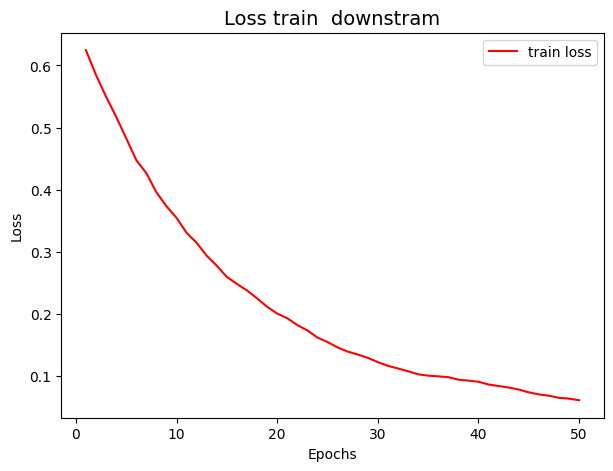

In [20]:
plt.figure(figsize=(7,5))

x_ax = np.arange(1, len(loss_train)+1) # Epochs
plt.plot(x_ax, loss_train, color='red', label='train loss')
#plt.plot(x_ax, loss_valid, color='orange', label='valid loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss train  downstram', size=14)
plt.legend()
plt.savefig('loss_train')


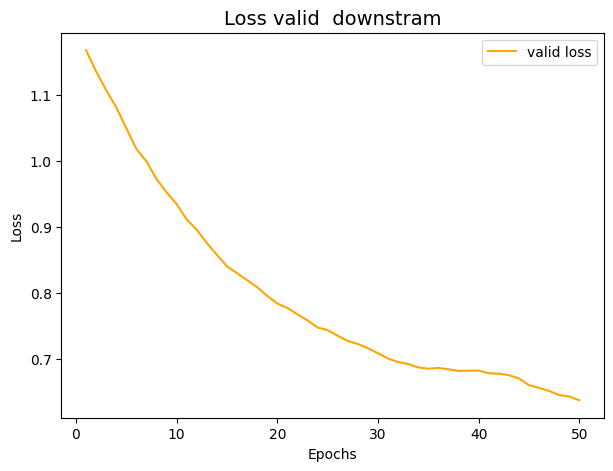

In [21]:
plt.figure(figsize=(7,5))

x_ax = np.arange(1, len(loss_train)+1) # Epochs
#plt.plot(x_ax, loss_train, color='red', label='train loss')
plt.plot(x_ax, loss_valid, color='orange', label='valid loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss valid  downstram', size=14)
plt.legend()
plt.savefig('loss_val')


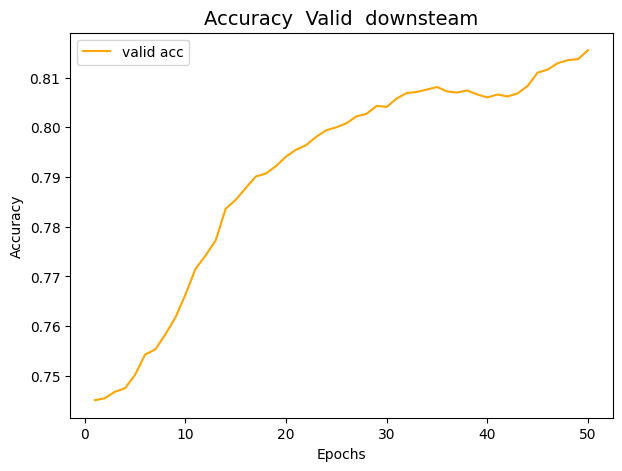

In [22]:
plt.figure(figsize=(7,5))
x_ax = np.arange(1, len(acc_train)+1) # Epochs
#plt.plot(x_ax, acc_train, color='red', label='train acc')
plt.plot(x_ax, acc_valid, color='orange', label='valid acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy  Valid  downsteam', size=14)
plt.legend()
plt.savefig('Accurary_val')

In [23]:
encoder_tsne = Encoder()

In [24]:
test_dataset_tsne = MNIST(root='./DATA', train=False, transform=test_transform, download=True)

test_loader_tsne = DataLoader(test_dataset_tsne, shuffle=True, num_workers=16, pin_memory=True, drop_last=True)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [25]:
encoder_tsne.load_state_dict(torch.load("./drive/MyDrive/Colab Notebooks/Projet Deep learning/moco_final_q.pt"))
encoder_tsne.eval()

Encoder(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
 

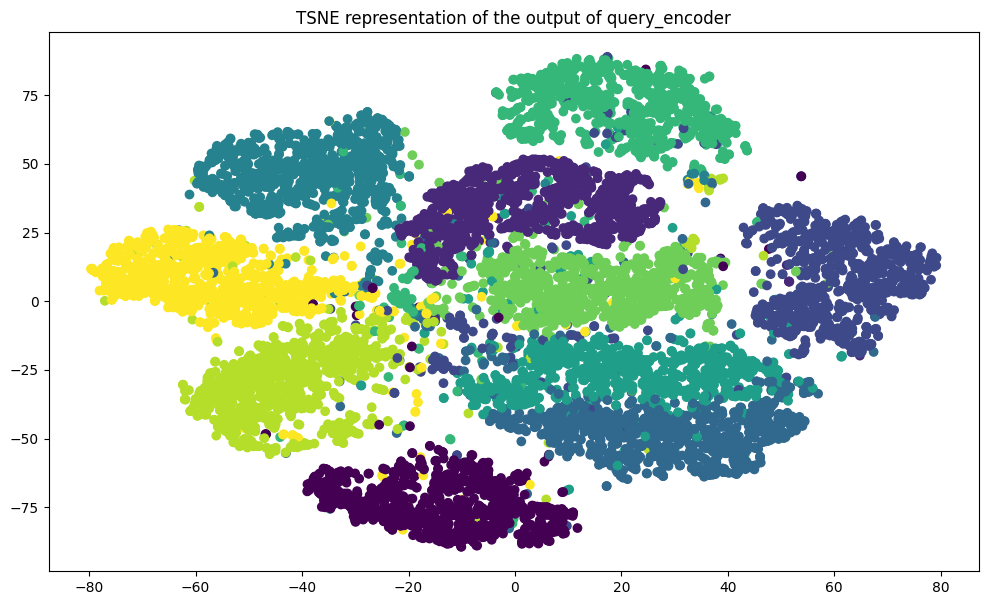

In [26]:

# Extracting the features from the dataset using the MoCo model
features = []
labels = []
with torch.no_grad():
    for data, target in test_dataset_tsne:
        features.append(encoder_tsne.forward(data.unsqueeze(0)).squeeze().cpu().numpy())
        labels.append(target)
features = np.array(features)
# We Apply t-SNE to the extracted features to create a 2D visualization

tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
embeddings = tsne.fit_transform(features)

# Plot the embeddings with the corresponding labels
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
plt.scatter(embeddings[:,0], embeddings[:,1], c=labels)
plt.title('TSNE representation of the output of query_encoder')
plt.savefig('moco_labels')
plt.show()


In [34]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()
      outputs = down_stream(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print('Accuracy of the classifier on the test set: %d %%' % (
    100 * correct / total))

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy of the classifier on the test set: 82 %
